<a href="https://colab.research.google.com/github/ustbzyt/autoconfig/blob/main/BELKA_Molecule_Representations_for_ML_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leash-BELKA:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F67356%2F8006601%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240701%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240701T224303Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7af8aa9c4ac888c3b0d8b2b0c8e7c861fb7f573dda6fc9d3f4bdd36f0ced931c4be47c801b64af5e622416e53d0bf83502a35b0c94e626404e9408fa5562384de6224110721f563e03c7ec9a0ef76bf2c5d558c52bb22230b593df54d1941401937ebb7f2c38627d94b4dd3fa8b2c661908c896c5fc08ddd63cc403dc2007b60725b45ce56bf9e30c1172c1ca838ed865035ed3fb4f12af2dee8ec2e8dec3105de321c56eaee691e48a81f37247781ff91021ad1911580a6c2d32bbb49af4b74ec8d22ae55870d0aff888a70555dff5bee17d562c24a9832e02352a7cd6cce9a2797ba6e376936ae05bf47af132901d16a9afd52d9cbbd7182e51864442d9863'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4467933750 bytes downloaded
Downloaded and uncompressed: leash-BELKA
Data source import complete.


# BELKA: Molecule Representations for ML Tutorial

Author:
- Stephen Lee ([LinkedIn](https://www.linkedin.com/in/stephendongsoolee/))

<a name="background"></a>
# 📖 Background
---

**SMILES (Simplified Molecular Input Line Entry System)** notation is a way of representing chemical structures as a string, allowing for easy input, storage, and manipulation of molecular data. The ability to convert these SMILES strings into meaningful numerical representations (embeddings) is crucial for applying machine learning techniques to chemical compounds.

This notebook aims to provide helpful, high-level material and demo code to generate various types of molecular embeddings that can be generated from SMILES and used for machine learning. Specifically, the following types of molecular embeddings are covered:
- [Descriptors](#descriptors)
- [Fingerprints](#fingerprints)
- [Graphs](#graph)
- [Mol2Vec Embeddings](#mol2vec)
- [Chemical Language Model Embeddings](#clm)

Please leave a comment if you have questions or suggestions!

<a name="setup"></a>
# 🛠️ Environment Setup
---

In [2]:
# for basic SMILES operations, descriptors and fingerprints
!pip install -q rdkit-pypi

# for graphs
!pip install -q dgl

# for mol2vec
!pip install -q mol2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for basic SMILES operations, descriptors and fingerprints
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

# for graphs
import dgl
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


ImportError: cannot import name 'DILL_AVAILABLE' from 'torch.utils.data.datapipes.utils.common' (/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py)

In [4]:
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

<a name="data"></a>
# 🗃️ Load Data
---

In [5]:
# load sample of training data for demo
df = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [6]:
# assign unique molecule_smiles values to variable. This is all we need for the purpose of this demo
smiles = df['molecule_smiles'].unique()
print(len(smiles))

334


SMILES can be converted into standardized data structures called Mol objects which provide rich representations of molecular structures. Many of the embedding generation featured in this notebook relies on Mol objects as input.

Mol objects are generated using the RDKit package, a widely used cheminformatics library for molecular modeling, chemical analysis and computational chemistry.

In [7]:
# obtain RDKit mol objects from SMILES
mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

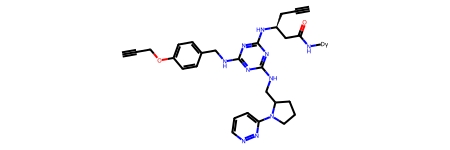

In [8]:
# mol objects can be readily viewed as 2d molecular drawings like so
mols[0]

<a name="descriptors"></a>
# 🧪 Molecular Descriptors
---

Molecular descriptors are quantitative properties that capture information about the chemical structure that can be used effectively in cheminformatics, particularly for the modeling and analysis of chemical compounds. Descriptors can pertain to various aspects of a chemical structure, such as its constitution, topology, geometry, electron distribution, and hydrophobicity.

The following code demonstrates how to generate molecular descriptors from SMILES.

References:
- [RDKit Documentation](https://www.rdkit.org/docs/)
- [RDKit GitHub](https://github.com/rdkit/rdkit)

In [9]:
# generate RDKit descriptors from Mol objects
def generate_descriptors(mols):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    mol_descriptors = []
    for mol in mols:
        rdkit_descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(rdkit_descriptors)

    desc_names = calc.GetDescriptorNames()
    return pd.DataFrame(mol_descriptors, columns=desc_names)

descriptor_df = generate_descriptors(mols)
descriptor_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.022584,-0.351126,12.022584,0.147985,0.183859,702.124,670.876,703.192320,215,0,...,0,0,0,2,0,0,0,0,0,0
1,11.915654,-0.355972,11.915654,0.156881,0.156604,710.925,686.733,711.049734,193,0,...,0,0,0,2,0,0,0,0,0,0
2,11.962513,-0.366334,11.962513,0.159820,0.179210,685.089,656.865,686.154538,207,0,...,0,0,0,3,0,0,0,0,0,0
3,11.876213,-0.380871,11.876213,0.144780,0.109711,652.060,622.828,653.165437,197,0,...,0,0,0,2,0,0,0,0,1,0
4,11.954303,-0.403060,11.954303,0.054611,0.142767,638.033,610.817,639.149787,191,0,...,0,0,0,2,0,0,0,0,0,0


Since molecular descriptors directly represent some characteristic of a chemical structure, they are readily usable for analysis. For example, you could examine the relationship between molecular weight and logP (measure of hydrophobicity):

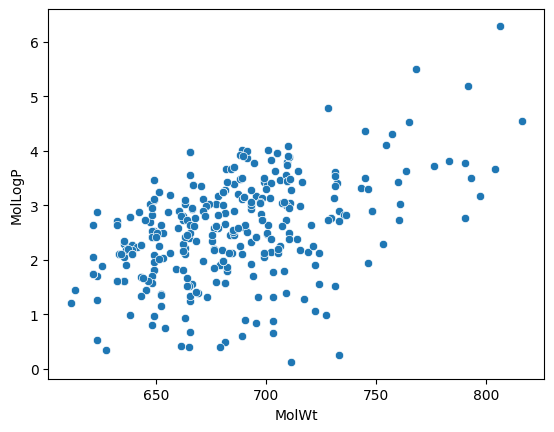

In [10]:
sns.scatterplot(x='MolWt', y='MolLogP', data=descriptor_df)
plt.show()

<a name="fingerprints"></a>
# 🗝️ Molecular Fingerprints
---
**Molecular fingerprints** are fixed-length numerical representations that encode molecular structures, usually as a binary vector. Each element (called a bit) of a fingerprint vector represents the presence of specific atomic or structural features within the chemical compound.

Below is example code to generate two types of commonly used molecular fingerprints:
- **MACCS Keys**: a 166-bit fingerprint based on a predefined list of molecular substructures or patterns
- **Morgan Fingerprints**: a fixed-length bit fingerprint based on hashed topological features of atoms and their bond connectivities within a specified radius. Also referred to as Extended-Connectivity Fingerprints (ECFPs)

References::
- Durant, J. L., Leland, B. A., Henry, D. R., & Nourse, J. G. (2002). Reoptimization of MDL keys for use in drug discovery. Journal of Chemical Information and Computer Sciences, 42(6), 1273-1280. [Link to Article](https://pubs.acs.org/doi/10.1021/ci010132r)
- Rogers, D., & Hahn, M. (2010). Extended-connectivity fingerprints. Journal of Chemical Information and Modeling, 50(5), 742-754. [Link to Article](https://pubs.acs.org/doi/10.1021/ci100050t)

In [11]:
# generate MACCS Keys from RDKit Mol objects as a dataframe
maccs_list = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

maccs_data = []
for maccs in maccs_list:
    bit_array = list(map(int, maccs.ToBitString()))
    maccs_data.append(bit_array[1:])  # skip 1st bit as it is unused in RDKit's MACCSkeys.GenMACCSKeys implementation

maccs_df = pd.DataFrame(maccs_data)
maccs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
1,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


In [12]:
# generate Morgan Fingerprints from RDKit Mol objects as a dataframe
mfpt_list = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

mfpt_df = pd.DataFrame([list(fpt) for fpt in mfpt_list])
mfpt_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note that different values can be specified for radius and nBits when generating Morgan Fingerprints.
- **radius:** number of bond steps to include from each atom when calculating the fingerprint. A radius of 1 means that only the immediate neighbors are considered; a radius of 2 includes neighbors up to two bonds away, etc.
- **nBits:** total number of bits in the fingerprint (i.e. resolution). Larger nBits values increases feature dimensionality and typically increases feature sparsity.

**Bit Collision** refers to the scenario where different substructural features are mapped to the same bit position. This is undesirable as it reduces the fingerprint's ability to differentiate molecules. Increasing nBits increases the available feature space and thus lowers the chance of bit collisions.

<a name="graph"></a>
# ⚛️ Molecular Graph Embeddings
---
A graph is a type of data structure to represent some interconnected entitiy (e.g. social networks). Molecules can be represented as graphs with atoms as nodes and bonds as edges.

Below is example code to generate graphs from RDKit Mol objects using the Deep Graph Learning (DGL) package.

References::
- Wang, M., Zheng, D., Ye, Z., Gan, Q., Li, M., Song, X., Zhou, J., Ma, C., Yu, L., Gai, Y., Xiao, T., He, T., Karypis, G., Li, J., & Zhang, Z. (2019). Deep graph library: A graph-centric, highly-performant package for graph neural networks. [Link to Article](https://arxiv.org/abs/1909.01315)
- [Deep Graph Libarary Docs](https://docs.dgl.ai/)

In [13]:
# generate molecular graphs from RDKit Mol objects
def mol_to_dgl_graph(mol):
    graph = dgl.DGLGraph()

    # add nodes
    num_atoms = mol.GetNumAtoms()
    graph.add_nodes(num_atoms)

    # add edges
    for bond in mol.GetBonds():
        # DGL graphs are directed so both directions are added
        graph.add_edges(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        graph.add_edges(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())

    # add node features - e.g. atomic number
    node_feats = torch.tensor([[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=torch.float32)
    graph.ndata['feat'] = node_feats

    # add edge features (optional) - e.g. bond type: single/double/triple as 1, 2, 3
    edge_feats = []
    for bond in mol.GetBonds():
        bond_type = bond.GetBondTypeAsDouble()
        edge_feats.append([bond_type])
        edge_feats.append([bond_type])  # add both directions
    graph.edata['type'] = torch.tensor(edge_feats, dtype=torch.float32)

    return graph

graphs = mols.apply(mol_to_dgl_graph)
print(graphs)

NameError: name 'dgl' is not defined

In [ ]:
# graph neural networks typically process graphs in batches for efficiency
batched_graph = dgl.batch(graphs.tolist())
batched_graph

<a name="mol2vec"></a>
# 💬 Mol2Vec Embeddings
---
Mol2Vec is a version of the widespread natural language processing (NLP) algorithm Word2vec, specifically adapted for molecular data. Mol2Vec represents molecules in a continuous vector space that captures chemical similarity in a mannner that is analagous to how Word2Vec captures semantic similarity between words. Mol2Vec treats chemical substructures (e.g. Morgan fingerprints with radius=1) as fundamental units of a 'molecular sentence', similar to how words are treated in NLP.

A Mol2Vec model pre-trained on 20 million molecules is available to generate 300 dimensional embeddings based on learned molecular vector representations. Below is example code to generate Mol2Vec embeddings

References:
- Jaeger, S., Fulle, S., & Turk, S. (2018). Mol2vec: unsupervised machine learning approach with chemical intuition. Journal of Chemical Information and Modeling, 58(1), 27-35. [Link to Article](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616)
- [Mol2Vec GitHub Repo](https://github.com/samoturk/mol2vec)

In [ ]:
# load pre-trained mol2vec model
mol2vec_url = 'https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl'
mol2vec_model = word2vec.Word2Vec.load(mol2vec_url)

In [ ]:
# generate molecular sentences
mol_sentences = mols.apply(lambda x: MolSentence(mol2alt_sentence(x, 1)))

# version of sentences2vec() compatible with gensim v4.0 (source: https://github.com/samoturk/mol2vec/issues/14)
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

# generate vector embeddings from molecular sentences
mol2vec_embeddings = np.array([DfVec(x) for x in sentences2vec(mol_sentences, mol2vec_model, unseen='UNK')])
mol2vec_embeddings[:5]

<a name="clm"></a>
# 🤖 Chemical Language Model Embeddings
---

Just as traditional language models use self-attention mechanisms to compute the representation of each language element (e.g. word in a sentence) to every other element, chemical language models use the same principle in which elements are some chemical unit (e.g. atoms) instead of words.

Below is example code to obtain learned transformer-based embeddings from two chemical language models:
- ChemBERTa: adapted for chemical SMILES from the RoBERTa architecture, trained on a dataset of 77 million molecules
- MoLFormer: another transformer-based model adapted for SMILES but trained on a larger dataset (1.1 billion molecules!)

References:
- Chithrananda, S., Grand, G., & Ramsundar, B. (2020). ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction. [Link to Article](https://arxiv.org/abs/2010.09885)
- Chithrananda, S., Grand, G., & Ramsundar, B. (2022). ChemBERTa-2: Towards Chemical Foundation Models. [Link to Article](https://arxiv.org/abs/2209.01712)
- Ross, J., Belgodere, B., Chenthamarakshan, V., et al. (2022). Large-scale chemical language representations capture molecular structure and properties. Nature Machine Intelligence, 4, 1256-1264. [Link to Article](https://www.nature.com/articles/s42256-022-00580-7)
- [ChemBERTa on HuggingFace Model Repo](https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1)
- [MolFormer on HuggingFace Model Repo](https://huggingface.co/ibm/MoLFormer-XL-both-10pct)
- [MolFormer GitHub repo](https://github.com/IBM/molformer)

In [14]:
# load pre-trained ChemBERTa model checkpoint and tokenizer
cb_tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model = AutoModel.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model.eval()

# tokenize SMILES
cb_encoded_inputs = cb_tokenizer(list(smiles), padding=True, truncation=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = cb_model(**cb_encoded_inputs)

# extract pooled output
cb_embeddings = outputs.pooler_output

cb_embeddings_df = pd.DataFrame(cb_embeddings.numpy())
cb_embeddings_df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.186745,-0.057917,0.046817,0.340886,-0.090008,0.240274,0.340781,0.192742,0.393116,-0.181079,...,-0.359442,-0.390653,0.191411,-0.182616,-0.390144,-0.107753,0.144431,0.342074,-0.142274,0.290290
1,0.141925,-0.124088,0.089983,0.367972,-0.048604,0.139213,0.264395,0.261047,0.256142,-0.260401,...,-0.352318,-0.384370,0.011389,-0.118333,-0.272366,-0.171003,0.117081,0.324919,-0.228456,0.262648
2,0.175464,-0.115291,0.097895,0.379004,-0.067050,0.217342,0.248708,0.270211,0.262761,-0.148038,...,-0.334320,-0.313021,0.095209,-0.214807,-0.330768,-0.134719,0.134001,0.310502,-0.215079,0.307924
3,0.236960,-0.160193,0.215229,0.363184,-0.053767,0.201949,0.148038,0.271465,0.345710,-0.291371,...,-0.462296,-0.378172,-0.018567,-0.085523,-0.348455,-0.082521,0.135652,0.305564,-0.328181,0.421196
4,0.242171,-0.260412,0.220570,0.340457,0.002597,0.193601,0.161918,0.236263,0.286874,-0.293151,...,-0.435794,-0.309164,-0.010794,-0.030670,-0.331016,-0.106562,0.113174,0.225306,-0.326991,0.306110


In [15]:
# load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModel.from_pretrained('ibm/MoLFormer-XL-both-10pct', trust_remote_code=True)

# tokenize SMILES
mf_encoded_inputs = mf_tokenizer(list(smiles), padding=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = mf_model(**mf_encoded_inputs)

# extract embeddings
mf_embeddings = outputs.pooler_output

mf_embeddings_df = pd.DataFrame(mf_embeddings.numpy())
mf_embeddings_df.head()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.376307,-0.046015,0.153858,0.445688,-0.103085,-0.104104,0.586607,-0.031614,0.114305,0.132850,...,-0.318594,-0.524100,-0.022059,0.032010,0.520937,-0.325911,-3.315281,-0.223676,-0.419200,-0.374853
1,-0.091439,-0.046942,0.280922,0.289476,-0.065729,0.090521,0.874730,-0.222022,0.187956,0.162284,...,-0.536932,-0.851344,-0.226594,-0.018249,0.592819,-0.202552,-3.305559,-0.428978,-0.634329,-0.290279
2,0.053989,-0.178976,0.763154,0.470574,-0.120402,0.065201,0.778041,-0.194139,-0.115894,0.113018,...,-0.452373,-0.596588,-0.234261,-0.100918,0.379302,-0.072905,-3.204520,-0.388134,-0.538523,-0.574767
3,-0.274843,-0.196689,0.498238,0.530901,-0.242904,0.035078,0.434244,-0.063382,0.037382,0.208610,...,-0.377203,-0.557990,-0.175017,-0.062944,0.420030,-0.168075,-2.947413,-0.445214,-0.594446,-0.159752
4,-0.020652,-0.264256,0.591574,0.334675,-0.267121,0.107243,0.608527,0.022912,-0.198581,0.167179,...,-0.258957,-0.757061,-0.198402,0.012355,0.593398,-0.074789,-2.919329,-0.245241,-0.668333,-0.280909
